# Import the necessary libraries

In [214]:
import pandas as pd
import numpy as np
from keras import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
%matplotlib inline

In [215]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#Preprocessing 
Drop the columns that are not requried for the neural network.

In [216]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

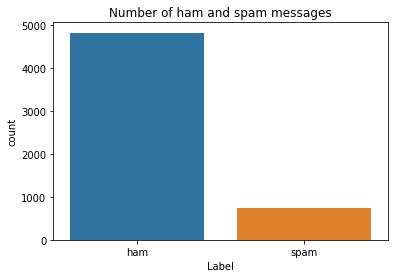

In [218]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

* Create input and output vectors.
* Process the labels.

In [219]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split into training and test data.

In [220]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

Padding the words to get equal length for all words in a sentence

In [221]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = utils.pad_sequences(sequences,maxlen=max_len)

In [222]:
sequences_matrix.shape

(4736, 150)

In [223]:
sequences_matrix.ndim

2

In [224]:
sequences_matrix = np.reshape(sequences_matrix,(4736,150,1))

In [225]:
sequences_matrix.ndim #3d shape verification to proceed to RNN LSTM

3

# RNN Construction
Create model for RNN

In [226]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [227]:
model = Sequential()

In [228]:
model.add(Embedding(max_words,50,input_length=max_len))

In [229]:
model.add(LSTM(units=64,input_shape = (sequences_matrix.shape[1],1),return_sequences=True))

In [230]:
model.add(LSTM(units=64,return_sequences=True))

In [231]:
model.add(LSTM(units=64,return_sequences=True))

In [232]:
model.add(LSTM(units=64))

In [233]:
model.add(Dense(units = 256,activation = 'relu'))

In [234]:
model.add(Dense(units = 1,activation = 'sigmoid'))

In [235]:
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 150, 50)           50000     
                                                                 
 lstm_37 (LSTM)              (None, 150, 64)           29440     
                                                                 
 lstm_38 (LSTM)              (None, 150, 64)           33024     
                                                                 
 lstm_39 (LSTM)              (None, 150, 64)           33024     
                                                                 
 lstm_40 (LSTM)              (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 256)               16640     
                                                                 
 dense_13 (Dense)            (None, 1)                

###Fit on the training data.

In [241]:
M = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=5,validation_split=0.2)
M

Epoch 1/5
30/30 [==============================] - 38s 1s/step - loss: 0.0277 - accuracy: 0.9931 - val_loss: 0.1112 - val_accuracy: 0.9778
Epoch 2/5
30/30 [==============================] - 37s 1s/step - loss: 0.0220 - accuracy: 0.9934 - val_loss: 0.0896 - val_accuracy: 0.9810
Epoch 3/5
30/30 [==============================] - 36s 1s/step - loss: 0.0148 - accuracy: 0.9942 - val_loss: 0.1356 - val_accuracy: 0.9800
Epoch 4/5
30/30 [==============================] - 35s 1s/step - loss: 0.0103 - accuracy: 0.9963 - val_loss: 0.1724 - val_accuracy: 0.9715
Epoch 5/5
30/30 [==============================] - 35s 1s/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.2044 - val_accuracy: 0.9800


###Saving the model

In [242]:
model.save

<bound method Model.save of <keras.engine.sequential.Sequential object at 0x7fc214ad6310>>

The model performs well on the validation set and this configuration is chosen as the final model.

###Evaluate the model on test set data.

In [243]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = utils.pad_sequences(test_sequences,maxlen=max_len)

In [244]:
accr = model.evaluate(test_sequences_matrix,Y_test)


27/27 [==============================] - 5s 172ms/step - loss: 0.1001 - accuracy: 0.9844


In [245]:
l = accr[0]
a =accr[1]
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(l,a))

Test set
  Loss: 0.100
  Accuracy: 0.984


### Accuracy and Loss Graph

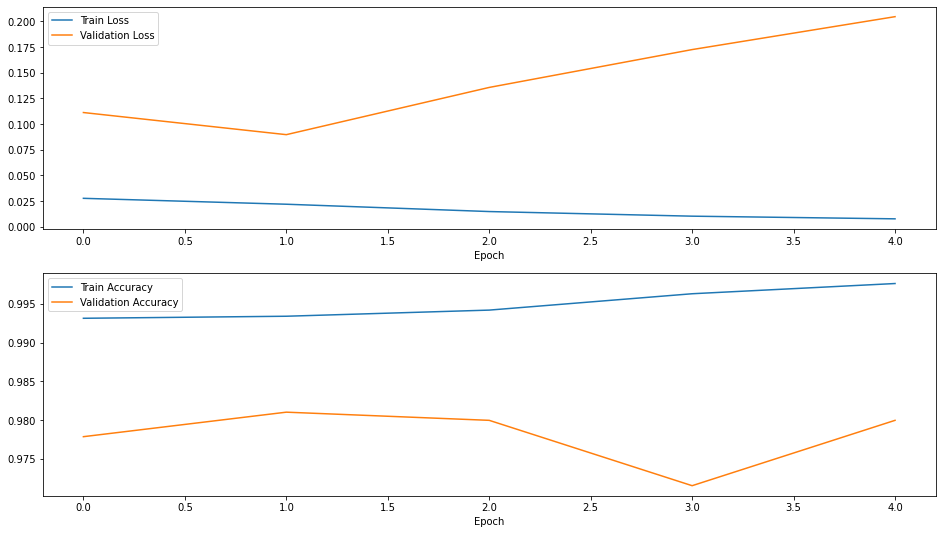

In [250]:
results = pd.DataFrame({"Train Loss": M.history['loss'], "Validation Loss": M.history['val_loss'],
              "Train Accuracy": M.history['accuracy'], "Validation Accuracy": M.history['val_accuracy']
             })
fig, ax = plt.subplots(nrows=2, figsize=(16, 9))
results[["Train Loss", "Validation Loss"]].plot(ax=ax[0])
results[["Train Accuracy", "Validation Accuracy"]].plot(ax=ax[1])
ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
plt.show()
